# Setup

In [1]:
%pylab --no-import-all inline
import matplotlib as mpl

Populating the interactive namespace from numpy and matplotlib


Don't necessarily actually want the figures to be inline (not really necessary here as I really just want to save them)

In [19]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

In [2]:
import ParaTemp.CoordinateAnalysis as ca

from ParaTemp import cd
import pandas as pd

import os

import MDAnalysis
import MDAnalysis as mda
import MDAnalysis.analysis.rdf as mdardf
from MDAnalysis.analysis.base import AnalysisBase

In [3]:
configs = {'MaEn': 'major-endo/13-3htmf-etc/05',
           'MaEx': 'major-exo/13-3htmf-etc/05',
           'MiEn': 'minor-endo/13-3htmf-etc/05',
           'MiEx': 'minor-exo/13-3htmf-etc/05'
          }

In [177]:
reload(ca)

<module 'ParaTemp.CoordinateAnalysis' from '/usr3/graduate/theavey/.local/lib/python2.7/site-packages/ParaTemp/CoordinateAnalysis.py'>

# Test stuff

In [15]:
i = 0
key = 'MaEn'
with cd(configs[key]):
    univ = ca.Taddol('../../../solutes.gro', 
                             'npt-PT-{}-out{}.xtc'.format(key, i))

In [23]:
final_time = str(int(univ.data['Time'].iat[-1]/1000))+'ns'
print final_time

775ns


In [30]:
with cd(configs[key]):
    with open('TOPO/temperatures.dat', 'r') as t_file:
        temps = list(t_file.read()[1:-2].split(', '))
print temps
print type(temps)

['205.0', '215.51057475708495', '226.5600382055078', '238.17601975929801', '250.38756542283483', '263.22521042098697', '276.72105555308065', '290.90884746161777', '305.8240630164604', '321.50399802548463', '337.9878604935263', '355.31686866281603', '373.53435408005436', '392.68586994784874', '412.8193050314477', '433.9850034055983']
<type 'list'>


In [5]:
for key in configs:
    print key

MaEx
MiEn
MiEx
MaEn


# Run it

In [6]:
for key in configs:
    with cd(configs[key]):
        with open('TOPO/temperatures.dat', 'r') as t_file:
            temps = list(t_file.read()[1:-2].split(', '))
        fig_fes_cvs, axes_fes_cvs = plt.subplots(4, 4, sharex=True, sharey=True)
        fig_fes_cvs_open, axes_fes_cvs_open = plt.subplots(4, 4, sharex=True, sharey=True)
        fig_fes_cvs_closed, axes_fes_cvs_closed = plt.subplots(4, 4, sharex=True, sharey=True)
        fig_fes_ox_dists, axes_fes_ox_dists = plt.subplots(4, 4, sharex=True, sharey=True)
        for i in xrange(16):
            print 'Now starting on {} {}...'.format(key, i)
            temp = float(temps[i])
            univ = ca.Taddol('../../../solutes.gro', 
                             'npt-PT-{}-out{}.xtc'.format(key, i))
            final_time = str(int(univ.data['Time'].iat[-1]/1000))+'ns'
            file_name_end = '-rjm-PT-{}-{}-{}.pdf'.format(key, i, final_time)
            if os.path.isfile('fes-ox-dists'+file_name_end):
                print '{} {} seems to already '.format(key, i) \
                      'be complete; moving on...'
                continue
            try:
                univ.read_data()
            except IOError:
                univ.calculate_distances()
                univ.save_data()
            univ.calc_open_closed()  # This is fast, so doesn't really matter if repeated
            print 'Done importing and calculating, making figures...'
            
            ax = axes_fes_cvs.flat[i]
            univ.fes_2d_cvs(temp=temp, display=False, ax=ax)
            filename = 'fes-cvs'+file_name_end
            if not os.path.isfile(filename):
                fig = univ.fes_2d_cvs(temp=temp)
                fig.savefig(filename)
            
            if len(univ.data[univ.data['open_TAD']]['CV1']) > 1:
                ax = axes_fes_cvs_open.flat[i]
                univ.fes_2d_cvs(univ.data[univ.data['open_TAD']]['CV1'], 
                                univ.data[univ.data['open_TAD']]['CV2'],
                                temp=temp, display=False, ax=ax)
                filename = 'fes-cvs-open'+file_name_end
                if not os.path.isfile(filename):
                    fig = univ.fes_2d_cvs(univ.data[univ.data['open_TAD']]['CV1'], 
                                          univ.data[univ.data['open_TAD']]['CV2'],
                                          temp=temp)
                    fig.savefig(filename)
            else:
                print '\n\n!!!! Not enough data to plot for open ' \
                      '{} {} !!!!\n\n'.format(key, i)
            
            if len(univ.data[univ.data['closed_TAD']]['CV1']) > 1:
                ax = axes_fes_cvs_closed.flat[i]
                univ.fes_2d_cvs(univ.data[univ.data['closed_TAD']]['CV1'], 
                                univ.data[univ.data['closed_TAD']]['CV2'],
                                temp=temp, display=False, ax=ax)
                filename = 'fes-cvs-closed'+file_name_end
                if not os.path.isfile(filename):
                    fig = univ.fes_2d_cvs(univ.data[univ.data['closed_TAD']]['CV1'], 
                                          univ.data[univ.data['closed_TAD']]['CV2'],
                                          temp=temp)
                    fig.savefig(filename)
            else:
                print '\n\n!!!! Not enough data to plot for closed ' \
                      '{} {} !!!!\n\n'.format(key, i)
            
            ax = axes_fes_ox_dists.flat[i]
            univ.fes_ox_dists(temp=temp, save=False, display=False, linewidth=3,
                              ax=ax)
            filename = 'fes-ox-dists'+file_name_end
            if not os.path.isfile(filename):
                fig = univ.fes_ox_dists(temp=temp, save=False, display=True, 
                                        linewidth=3)
                fig.savefig(filename)
            print('Done making and saving figures for '
                  '{} {}, closing and moving on...'.format(key, i))
            #plt.close('all')  # Not necessary because they pass out of scope?
        fig_fes_cvs.savefig('fes-cvs-rjm-PT-{}-comb-{}.pdf'.format(key, final_time))
        fig_fes_cvs_open.savefig('fes-cvs-open-rjm-PT-{}-comb-{}.pdf'.format(key, final_time))
        fig_fes_cvs_closed.savefig('fes-cvs-closed-rjm-PT-{}-comb-{}.pdf'.format(key, final_time))
        fig_fes_ox_dists.savefig('fes-ox-dists-rjm-PT-{}-comb-{}.pdf'.format(key, final_time))
        print '\n\n---Done with all {}, moving to next config'.format(key)

Now starting on MaEn 0...
"all" given or implied, calculating distances for oxygens and CVs
Done importing and calculating, making figures...


!!!! Not enough data to plot for closed MaEn 0 !!!!


Done making and saving figures for MaEn 0, closing and moving on...
Now starting on MaEn 1...
"all" given or implied, calculating distances for oxygens and CVs
Done importing and calculating, making figures...


!!!! Not enough data to plot for closed MaEn 1 !!!!


Done making and saving figures for MaEn 1, closing and moving on...
Now starting on MaEn 2...
"all" given or implied, calculating distances for oxygens and CVs
Done importing and calculating, making figures...
Done making and saving figures for MaEn 2, closing and moving on...
Now starting on MaEn 3...
"all" given or implied, calculating distances for oxygens and CVs
Done importing and calculating, making figures...
Done making and saving figures for MaEn 3, closing and moving on...
Now starting on MaEn 4...
"all" given or implied

##### Output from a nearly complete run:

Output from a nearly complete run that died at the end:

Now starting on MiEx 0...
"all" given or implied, calculating distances for oxygens and CVs
Done importing and calculating, making figures...


!!!! Not enough data to plot for closed MiEx 0 !!!!


Done making and saving figures for MiEx 0, closing and moving on...
Now starting on MiEx 1...
"all" given or implied, calculating distances for oxygens and CVs
Done importing and calculating, making figures...


!!!! Not enough data to plot for closed MiEx 1 !!!!


Done making and saving figures for MiEx 1, closing and moving on...
Now starting on MiEx 2...
"all" given or implied, calculating distances for oxygens and CVs
Done importing and calculating, making figures...
Done making and saving figures for MiEx 2, closing and moving on...
Now starting on MiEx 3...
"all" given or implied, calculating distances for oxygens and CVs
Done importing and calculating, making figures...


!!!! Not enough data to plot for closed MiEx 3 !!!!


Done making and saving figures for MiEx 3, closing and moving on...
Now starting on MiEx 4...
"all" given or implied, calculating distances for oxygens and CVs
Done importing and calculating, making figures...
Done making and saving figures for MiEx 4, closing and moving on...
Now starting on MiEx 5...
"all" given or implied, calculating distances for oxygens and CVs
Done importing and calculating, making figures...
Done making and saving figures for MiEx 5, closing and moving on...
Now starting on MiEx 6...
"all" given or implied, calculating distances for oxygens and CVs
Done importing and calculating, making figures...
Done making and saving figures for MiEx 6, closing and moving on...
Now starting on MiEx 7...
"all" given or implied, calculating distances for oxygens and CVs
Done importing and calculating, making figures...
Done making and saving figures for MiEx 7, closing and moving on...
Now starting on MiEx 8...
"all" given or implied, calculating distances for oxygens and CVs
Done importing and calculating, making figures...
Done making and saving figures for MiEx 8, closing and moving on...
Now starting on MiEx 9...
"all" given or implied, calculating distances for oxygens and CVs
Done importing and calculating, making figures...
Done making and saving figures for MiEx 9, closing and moving on...
Now starting on MiEx 10...
"all" given or implied, calculating distances for oxygens and CVs
Done importing and calculating, making figures...
Done making and saving figures for MiEx 10, closing and moving on...
Now starting on MiEx 11...
"all" given or implied, calculating distances for oxygens and CVs
Done importing and calculating, making figures...
Done making and saving figures for MiEx 11, closing and moving on...
Now starting on MiEx 12...
"all" given or implied, calculating distances for oxygens and CVs
Done importing and calculating, making figures...
Done making and saving figures for MiEx 12, closing and moving on...
Now starting on MiEx 13...
"all" given or implied, calculating distances for oxygens and CVs
Done importing and calculating, making figures...
Done making and saving figures for MiEx 13, closing and moving on...
Now starting on MiEx 14...
"all" given or implied, calculating distances for oxygens and CVs
Done importing and calculating, making figures...
Done making and saving figures for MiEx 14, closing and moving on...
Now starting on MiEx 15...
"all" given or implied, calculating distances for oxygens and CVs
Done importing and calculating, making figures...
Done making and saving figures for MiEx 15, closing and moving on...


---Done with all MiEx, moving to next config
Now starting on MiEn 0...
"all" given or implied, calculating distances for oxygens and CVs
Done importing and calculating, making figures...
Done making and saving figures for MiEn 0, closing and moving on...
Now starting on MiEn 1...
"all" given or implied, calculating distances for oxygens and CVs
Done importing and calculating, making figures...
Done making and saving figures for MiEn 1, closing and moving on...
Now starting on MiEn 2...
"all" given or implied, calculating distances for oxygens and CVs
Done importing and calculating, making figures...


!!!! Not enough data to plot for closed MiEn 2 !!!!


Done making and saving figures for MiEn 2, closing and moving on...
Now starting on MiEn 3...
"all" given or implied, calculating distances for oxygens and CVs
Done importing and calculating, making figures...
Done making and saving figures for MiEn 3, closing and moving on...
Now starting on MiEn 4...
"all" given or implied, calculating distances for oxygens and CVs
Done importing and calculating, making figures...
Done making and saving figures for MiEn 4, closing and moving on...
Now starting on MiEn 5...
"all" given or implied, calculating distances for oxygens and CVs
Done importing and calculating, making figures...
Done making and saving figures for MiEn 5, closing and moving on...
Now starting on MiEn 6...
"all" given or implied, calculating distances for oxygens and CVs
Done importing and calculating, making figures...
Done making and saving figures for MiEn 6, closing and moving on...
Now starting on MiEn 7...
"all" given or implied, calculating distances for oxygens and CVs
Done importing and calculating, making figures...
Done making and saving figures for MiEn 7, closing and moving on...
Now starting on MiEn 8...
"all" given or implied, calculating distances for oxygens and CVs
Done importing and calculating, making figures...
Done making and saving figures for MiEn 8, closing and moving on...
Now starting on MiEn 9...
"all" given or implied, calculating distances for oxygens and CVs
Done importing and calculating, making figures...
Done making and saving figures for MiEn 9, closing and moving on...
Now starting on MiEn 10...
"all" given or implied, calculating distances for oxygens and CVs
Done importing and calculating, making figures...
Done making and saving figures for MiEn 10, closing and moving on...
Now starting on MiEn 11...
"all" given or implied, calculating distances for oxygens and CVs
Done importing and calculating, making figures...
Done making and saving figures for MiEn 11, closing and moving on...
Now starting on MiEn 12...
"all" given or implied, calculating distances for oxygens and CVs
Done importing and calculating, making figures...
Done making and saving figures for MiEn 12, closing and moving on...
Now starting on MiEn 13...
"all" given or implied, calculating distances for oxygens and CVs
Done importing and calculating, making figures...
Done making and saving figures for MiEn 13, closing and moving on...
Now starting on MiEn 14...
"all" given or implied, calculating distances for oxygens and CVs
Done importing and calculating, making figures...
Done making and saving figures for MiEn 14, closing and moving on...
Now starting on MiEn 15...
"all" given or implied, calculating distances for oxygens and CVs
Done importing and calculating, making figures...
Done making and saving figures for MiEn 15, closing and moving on...


---Done with all MiEn, moving to next config
Now starting on MaEn 0...
"all" given or implied, calculating distances for oxygens and CVs
Done importing and calculating, making figures...


!!!! Not enough data to plot for closed MaEn 0 !!!!


Done making and saving figures for MaEn 0, closing and moving on...
Now starting on MaEn 1...
"all" given or implied, calculating distances for oxygens and CVs
Done importing and calculating, making figures...


!!!! Not enough data to plot for closed MaEn 1 !!!!


Done making and saving figures for MaEn 1, closing and moving on...
Now starting on MaEn 2...
"all" given or implied, calculating distances for oxygens and CVs
Done importing and calculating, making figures...
Done making and saving figures for MaEn 2, closing and moving on...
Now starting on MaEn 3...
"all" given or implied, calculating distances for oxygens and CVs
Done importing and calculating, making figures...
Done making and saving figures for MaEn 3, closing and moving on...
Now starting on MaEn 4...
"all" given or implied, calculating distances for oxygens and CVs
Done importing and calculating, making figures...
Done making and saving figures for MaEn 4, closing and moving on...
Now starting on MaEn 5...
"all" given or implied, calculating distances for oxygens and CVs
Done importing and calculating, making figures...
Done making and saving figures for MaEn 5, closing and moving on...
Now starting on MaEn 6...
"all" given or implied, calculating distances for oxygens and CVs
Done importing and calculating, making figures...
Done making and saving figures for MaEn 6, closing and moving on...
Now starting on MaEn 7...
"all" given or implied, calculating distances for oxygens and CVs
Done importing and calculating, making figures...
Done making and saving figures for MaEn 7, closing and moving on...
Now starting on MaEn 8...
"all" given or implied, calculating distances for oxygens and CVs
Done importing and calculating, making figures...
Done making and saving figures for MaEn 8, closing and moving on...
Now starting on MaEn 9...
"all" given or implied, calculating distances for oxygens and CVs
Done importing and calculating, making figures...
Done making and saving figures for MaEn 9, closing and moving on...
Now starting on MaEn 10...
"all" given or implied, calculating distances for oxygens and CVs

# Combined open/closed FESs

## Test stuff

In [1]:
import pandas as pd
df = pd.DataFrame()

In [7]:
df['a'] = [1, 2]

In [11]:
ndf = None
np.histogram(ndf['b'])

TypeError: 'NoneType' object has no attribute '__getitem__'

In [14]:
tdf = pd.DataFrame(columns=['O-O', 'O(l)-Cy', 'O(r)-Cy'])

In [21]:
tdf.append(pd.DataFrame([[1,2,3], [2,3,4]], columns=['O-O', 'O(l)-Cy', 'O(r)-Cy']), in_p)

,O-O,O(l)-Cy,O(r)-Cy
0,1,2,3
1,2,3,4


In [22]:
tdf

,O-O,O(l)-Cy,O(r)-Cy


## Production

Now starting on MaEx 0...
Calculating oxygen distances...
This may take a few minutes.


/usr3/graduate/theavey/anaconda_envs/py2.7/lib/python2.7/site-packages/tables/path.py:112: NaturalNameWarning: object name is not a valid Python identifier: '754462'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)


Saved data to npt-PT-MaEx-out0.h5[754462]
Now starting on MiEn 0...
Calculating oxygen distances...
This may take a few minutes.


/usr3/graduate/theavey/anaconda_envs/py2.7/lib/python2.7/site-packages/tables/path.py:112: NaturalNameWarning: object name is not a valid Python identifier: '776242'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)


Saved data to npt-PT-MiEn-out0.h5[776242]
Now starting on MiEx 0...


/usr3/graduate/theavey/.local/lib/python2.7/site-packages/MDAnalysis/coordinates/XDR.py:126: UserWarning: Reload offsets from trajectory
 ctime or size or n_atoms did not match
  warnings.warn("Reload offsets from trajectory\n "


Calculating oxygen distances...
This may take a few minutes.


/usr3/graduate/theavey/anaconda_envs/py2.7/lib/python2.7/site-packages/tables/path.py:112: NaturalNameWarning: object name is not a valid Python identifier: '773192'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)


Saved data to npt-PT-MiEx-out0.h5[773192]
Now starting on MaEn 0...
Calculating oxygen distances...
This may take a few minutes.


/usr3/graduate/theavey/anaconda_envs/py2.7/lib/python2.7/site-packages/tables/path.py:112: NaturalNameWarning: object name is not a valid Python identifier: '775548'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)
/usr3/graduate/theavey/anaconda_envs/py2.7/lib/python2.7/site-packages/tables/path.py:112: NaturalNameWarning: object name is not a valid Python identifier: '750ns'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)


Saved data to npt-PT-MaEn-out0.h5[775548]
Now starting on MaEx 1...
Calculating oxygen distances...
This may take a few minutes.
Saved data to npt-PT-MaEx-out1.h5[754462]
Now starting on MiEn 1...
Calculating oxygen distances...
This may take a few minutes.
Saved data to npt-PT-MiEn-out1.h5[776242]
Now starting on MiEx 1...
Calculating oxygen distances...
This may take a few minutes.
Saved data to npt-PT-MiEx-out1.h5[773192]
Now starting on MaEn 1...
Calculating oxygen distances...
This may take a few minutes.
Saved data to npt-PT-MaEn-out1.h5[775548]
Now starting on MaEx 2...
Calculating oxygen distances...
This may take a few minutes.
Saved data to npt-PT-MaEx-out2.h5[754462]
Now starting on MiEn 2...
Calculating oxygen distances...
This may take a few minutes.
Saved data to npt-PT-MiEn-out2.h5[776242]
Now starting on MiEx 2...
Calculating oxygen distances...
This may take a few minutes.
Saved data to npt-PT-MiEx-out2.h5[773192]
Now starting on MaEn 2...
Calculating oxygen distances.

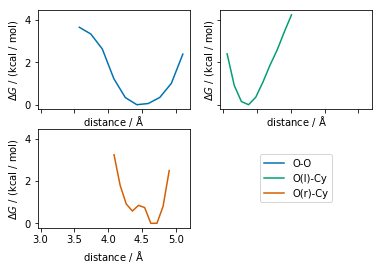

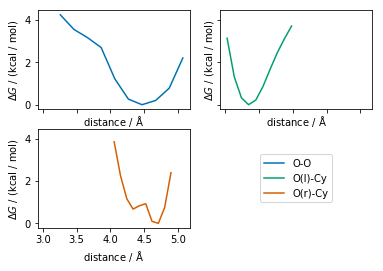

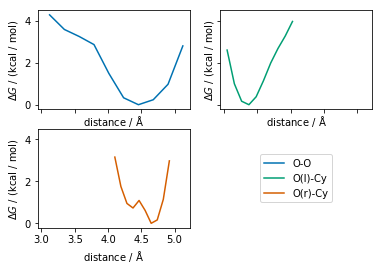

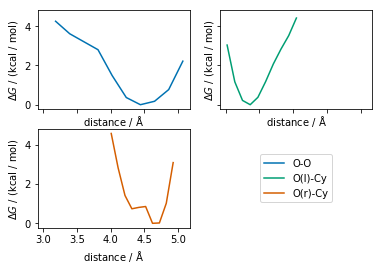

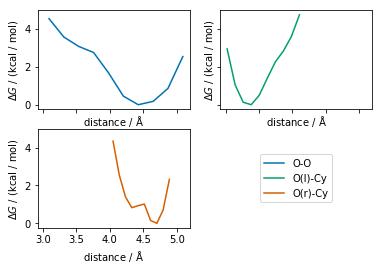

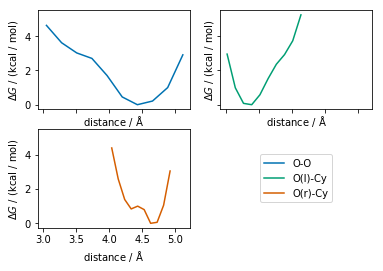

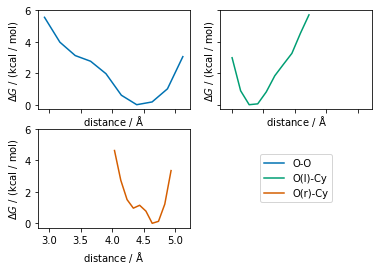

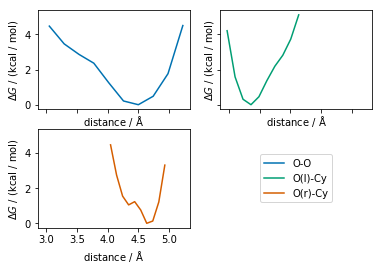

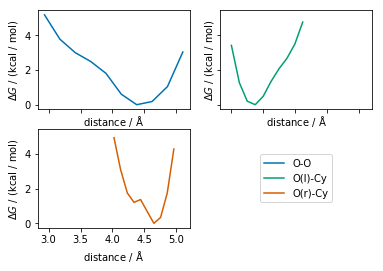

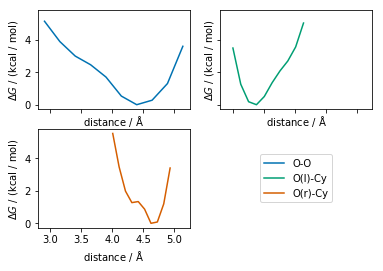

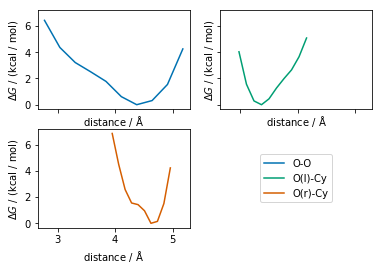

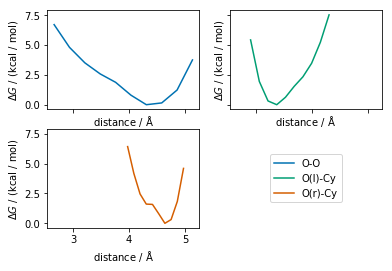

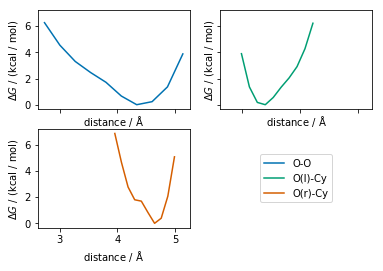

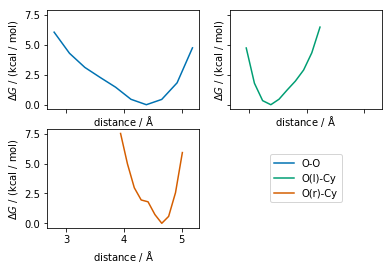

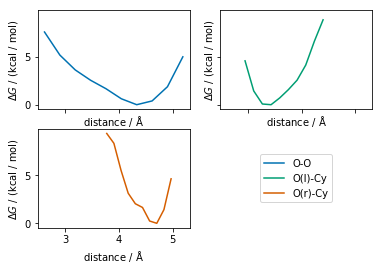

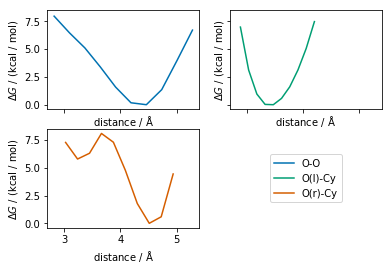

In [23]:
for i in xrange(16):
    comb_df = pd.DataFrame(columns=['O-O', 'O(l)-Cy', 'O(r)-Cy'])
    if os.path.exists('comb-o-data-{}.h5'.format(i)):
        with pd.HDFStore('comb-o-data-{}.h5'.format(i)) as store:
            try:
                comb_df = store['time_750ns']
            except KeyError:
                comb_df = store['750ns']
    else:
        for key in configs:
            with cd(configs[key]):
                with open('TOPO/temperatures.dat', 'r') as t_file:
                    temps = list(t_file.read()[1:-2].split(', '))
                temp = float(temps[i])
                print 'Now starting on {} {}...'.format(key, i)
                univ = ca.Taddol('../../../solutes.gro', 
                                 'npt-PT-{}-out{}.xtc'.format(key, i))
                try:
                    univ.read_data()
                except IOError:
                    save_data = True
                    pass
                else:
                    save_data = False
                comb_df = comb_df.append(univ.ox_dists, ignore_index=True)
                if save_data:
                    univ.save_data()
        with pd.HDFStore('comb-o-data-{}.h5'.format(i)) as store:
            store['time_750ns'] = comb_df
        print('Saved combined data as {}'.format('comb-o-data-{}.h5'.format(i)))
    fig = univ.fes_ox_dists(data=comb_df, temp=temp, linewidth=3)
    for axes in fig.axes[:3]:
        axes.set_ylim[0:8]
    fig.savefig('fes-ox-dists-rjm-PT-comb-{}.pdf'.format(i))
    plt.close('all')
    print('Saved figure as {}'.format('fes-ox-dists-rjm-PT-comb-{}.pdf'.format(i)))
    print('Done with temp {:.0f} K ({} of 16).'.format(temp, i+1) \
          ' Moving to next temperature...\n\n')

# Do Again at 1 us

## Playground

In [9]:
td = {'a': 1, 'b': 2}

In [10]:
td.update({'c': 3})

In [14]:
td.update(c=3)

In [15]:
td.update(c=3)

In [16]:
for key in td:
    print(key)

a
c
b


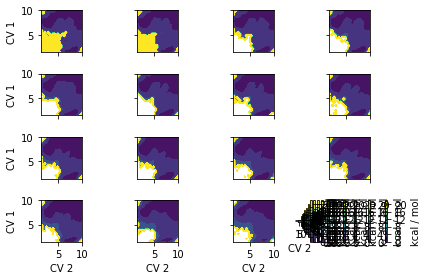

In [14]:
for axes in axes_fes_cvs[0:3]:
    for ax in axes:
        ax.set_xlabel('')
for axes in axes_fes_cvs[:,1:]:
    for ax in axes:
        ax.set_ylabel('')
fig_fes_cvs.tight_layout()
fig_fes_cvs

In [13]:
fig_fes_cvs.patches

[]

## Production

In [183]:
overwrite = True

for key in configs:
    with cd(configs[key]):
        with open('TOPO/temperatures.dat', 'r') as t_file:
            temps = list(t_file.read()[1:-2].split(', '))
        univ = ca.Taddol('../../../solutes.gro', 
                         'npt-PT-{}-out{}.xtc'.format(key, '0'))
        final_time = int(univ.data['Time'].iat[-1]/1000)
        if final_time >= 1000:
            final_time = str(final_time/1000)+'us'
        else:
            final_time = str(final_time) + 'ns'
        if os.path.isfile('fes-ox-dists-rjm-PT-{}-comb-{}.pdf'.format(key, final_time)) or not overwrite:
            print('\nAll of {} seems to be complete, moving on to next config...\n\n'.format(key))
            continue
        fig_fes_cvs, axes_fes_cvs = plt.subplots(4, 4, sharex=True, sharey=True)
        fig_fes_cvs_open, axes_fes_cvs_open = plt.subplots(4, 4, sharex=True, sharey=True)
        fig_fes_cvs_closed, axes_fes_cvs_closed = plt.subplots(4, 4, sharex=True, sharey=True)
        fig_fes_ox_dists, axes_fes_ox_dists = plt.subplots(8, 8, sharex=True, sharey=True)
        for i in xrange(16):
            print 'Now starting on {} {}...'.format(key, i)
            temp = float(temps[i])
            univ = ca.Taddol('../../../solutes.gro', 
                             'npt-PT-{}-out{}.xtc'.format(key, i))
            final_time = str(int(univ.data['Time'].iat[-1]/1000))+'ns'
            file_name_end = '-rjm-PT-{}-{}-{}.pdf'.format(key, i, final_time)
#             if os.path.isfile('fes-ox-dists'+file_name_end):
#                 print('{} {} seems to already '.format(key, i) +
#                       'be complete; moving on...')
#                 continue
            try:
                univ.read_data()
            except IOError:
                univ.calculate_distances()
                univ.save_data()
            univ.calc_open_closed()  # This is fast, so doesn't really matter if repeated
            print 'Done importing and calculating, making figures...'
            
            ax = axes_fes_cvs.flat[i]
            univ.fes_2d_cvs(temp=temp, display=False, ax=ax)
            filename = 'fes-cvs'+file_name_end
            if (not os.path.isfile(filename)) or overwrite:
                fig = univ.fes_2d_cvs(temp=temp)
                fig.savefig(filename)
            
            if len(univ.data[univ.data['open_TAD']]['CV1']) > 1:
                ax = axes_fes_cvs_open.flat[i]
                univ.fes_2d_cvs(univ.data[univ.data['open_TAD']]['CV1'], 
                                univ.data[univ.data['open_TAD']]['CV2'],
                                temp=temp, display=False, ax=ax)
                filename = 'fes-cvs-open'+file_name_end
                if (not os.path.isfile(filename)) or overwrite:
                    fig = univ.fes_2d_cvs(univ.data[univ.data['open_TAD']]['CV1'], 
                                          univ.data[univ.data['open_TAD']]['CV2'],
                                          temp=temp)
                    fig.savefig(filename)
            else:
                print '\n\n!!!! Not enough data to plot for open ' \
                      '{} {} !!!!\n\n'.format(key, i)
            
            if len(univ.data[univ.data['closed_TAD']]['CV1']) > 1:
                ax = axes_fes_cvs_closed.flat[i]
                univ.fes_2d_cvs(univ.data[univ.data['closed_TAD']]['CV1'], 
                                univ.data[univ.data['closed_TAD']]['CV2'],
                                temp=temp, display=False, ax=ax)
                filename = 'fes-cvs-closed'+file_name_end
                if (not os.path.isfile(filename)) or overwrite:
                    fig = univ.fes_2d_cvs(univ.data[univ.data['closed_TAD']]['CV1'], 
                                          univ.data[univ.data['closed_TAD']]['CV2'],
                                          temp=temp)
                    fig.savefig(filename)
            else:
                print '\n\n!!!! Not enough data to plot for closed ' \
                      '{} {} !!!!\n\n'.format(key, i)
            
            axes = axes_fes_ox_dists.flat[4*i:4*i+4]
            univ.fes_ox_dists(temp=temp, save=False, display=False, linewidth=3,
                              axes=axes)
            filename = 'fes-ox-dists'+file_name_end
            if (not os.path.isfile(filename)) or overwrite:
                fig = univ.fes_ox_dists(temp=temp, save=False, display=True, 
                                        linewidth=3)
                fig.savefig(filename)
            print('Done making and saving figures for '
                  '{} {}, closing and moving on...'.format(key, i))
            #plt.close('all')  # Not necessary because they pass out of scope?
        for axes in axes_fes_cvs[0:3]:
            for ax in axes:
                ax.set_xlabel('')
        for axes in axes_fes_cvs[:,1:]:
            for ax in axes:
                ax.set_ylabel('')
        fig_fes_cvs.tight_layout()
#         fig_fes_cvs.savefig('fes-cvs-rjm-PT-{}-comb-{}.pdf'.format(key, final_time))
        for axes in axes_fes_cvs_open[0:3]:
            for ax in axes:
                ax.set_xlabel('')
        for axes in axes_fes_cvs_open[:,1:]:
            for ax in axes:
                ax.set_ylabel('')
        fig_fes_cvs_open.tight_layout()
#         fig_fes_cvs_open.savefig('fes-cvs-open-rjm-PT-{}-comb-{}.pdf'.format(key, final_time))
        for axes in axes_fes_cvs_closed[0:3]:
            for ax in axes:
                ax.set_xlabel('')
        for axes in axes_fes_cvs_closed[:,1:]:
            for ax in axes:
                ax.set_ylabel('')
        fig_fes_cvs_closed.tight_layout()
#         fig_fes_cvs_closed.savefig('fes-cvs-closed-rjm-PT-{}-comb-{}.pdf'.format(key, final_time))
#         fig_fes_ox_dists.savefig('fes-ox-dists-rjm-PT-{}-comb-{}.pdf'.format(key, final_time))
        print '\n\n---Done with all {}, moving to next config'.format(key)
        plt.close('all')

Now starting on MaEx 0...
Done importing and calculating, making figures...
Using default data: self.ox_dists.
Using default data: self.ox_dists.
Done making and saving figures for MaEx 0, closing and moving on...
Now starting on MaEx 1...
Done importing and calculating, making figures...
Using default data: self.ox_dists.
Using default data: self.ox_dists.
Done making and saving figures for MaEx 1, closing and moving on...
Now starting on MaEx 2...
Done importing and calculating, making figures...
Using default data: self.ox_dists.
Using default data: self.ox_dists.
Done making and saving figures for MaEx 2, closing and moving on...
Now starting on MaEx 3...
Done importing and calculating, making figures...
Using default data: self.ox_dists.
Using default data: self.ox_dists.
Done making and saving figures for MaEx 3, closing and moving on...
Now starting on MaEx 4...
Done importing and calculating, making figures...
Using default data: self.ox_dists.
Using default data: self.ox_dists

Done importing and calculating, making figures...
Using default data: self.ox_dists.
Using default data: self.ox_dists.
Done making and saving figures for MiEx 5, closing and moving on...
Now starting on MiEx 6...
Done importing and calculating, making figures...
Using default data: self.ox_dists.
Using default data: self.ox_dists.
Done making and saving figures for MiEx 6, closing and moving on...
Now starting on MiEx 7...
Done importing and calculating, making figures...
Using default data: self.ox_dists.
Using default data: self.ox_dists.
Done making and saving figures for MiEx 7, closing and moving on...
Now starting on MiEx 8...
Done importing and calculating, making figures...
Using default data: self.ox_dists.
Using default data: self.ox_dists.
Done making and saving figures for MiEx 8, closing and moving on...
Now starting on MiEx 9...
Done importing and calculating, making figures...
Using default data: self.ox_dists.
Using default data: self.ox_dists.
Done making and saving f

## Combined Ox FESs Playground

In [20]:
fig.axes[:3]

In [21]:
axes.set_ylim

## Combined Ox FESs Production

In [23]:
for i in xrange(16):
    comb_df = pd.DataFrame(columns=['O-O', 'O(l)-Cy', 'O(r)-Cy'])
    if os.path.exists('comb-o-data-{}.h5'.format(i)):
        with pd.HDFStore('comb-o-data-{}.h5'.format(i)) as store:
            comb_df = store['time_1us']
    else:
        for key in configs:
            with cd(configs[key]):
                with open('TOPO/temperatures.dat', 'r') as t_file:
                    temps = list(t_file.read()[1:-2].split(', '))
                temp = float(temps[i])
                print 'Now starting on {} {}...'.format(key, i)
                univ = ca.Taddol('../../../solutes.gro', 
                                 'npt-PT-{}-out{}.xtc'.format(key, i))
                try:
                    univ.read_data()
                except IOError:
                    save_data = True
                    pass
                else:
                    save_data = False
                comb_df = comb_df.append(univ.ox_dists, ignore_index=True)
                if save_data:
                    univ.save_data()
        with pd.HDFStore('comb-o-data-{}.h5'.format(i)) as store:
            store['time_1us'] = comb_df
        print('Saved combined data as {}'.format('comb-o-data-{}.h5'.format(i)))
    fig = univ.fes_ox_dists(data=comb_df, temp=temp, linewidth=3)
    for axes in fig.axes[:3]:
        axes.set_ylim([0,8])
    fig.savefig('fes-ox-dists-rjm-PT-comb-{}.pdf'.format(i))
    plt.close('all')
    print('Saved figure as {}'.format('fes-ox-dists-rjm-PT-comb-{}.pdf'.format(i)))
    print('Done with temp {:.0f} K ({} of 16).'.format(temp, i+1) +
          ' Moving to next temperature...\n\n')

Saved figure as fes-ox-dists-rjm-PT-comb-0.pdf
Done with temp 205 K (1 of 16). Moving to next temperature...


Now starting on MaEx 1...
Now starting on MiEn 1...
Now starting on MiEx 1...
Now starting on MaEn 1...
Saved combined data as comb-o-data-1.h5
Saved figure as fes-ox-dists-rjm-PT-comb-1.pdf
Done with temp 216 K (2 of 16). Moving to next temperature...


Now starting on MaEx 2...
Now starting on MiEn 2...
Now starting on MiEx 2...
Now starting on MaEn 2...
Saved combined data as comb-o-data-2.h5
Saved figure as fes-ox-dists-rjm-PT-comb-2.pdf
Done with temp 227 K (3 of 16). Moving to next temperature...


Now starting on MaEx 3...
Now starting on MiEn 3...
Now starting on MiEx 3...
Now starting on MaEn 3...
Saved combined data as comb-o-data-3.h5
Saved figure as fes-ox-dists-rjm-PT-comb-3.pdf
Done with temp 238 K (4 of 16). Moving to next temperature...


Now starting on MaEx 4...
Now starting on MiEn 4...
Now starting on MiEx 4...
Now starting on MaEn 4...
Saved combined data 

# CV Ox Dist Cross Peak

## Playground

In [26]:
univ = ca.Taddol('solutes.gro', 'major-endo/13-3htmf-etc/05/npt-PT-MaEn-out0.xtc')
univ.read_data()

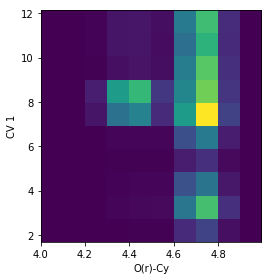

In [43]:
fig, ax = plt.subplots()
ax.hist2d(univ.data['O(r)-Cy'], univ.data['CV1'])
ax.set_aspect(0.1,'box-forced')
ax.set_xlabel('O(r)-Cy')
ax.set_ylabel('CV 1')
fig.tight_layout()
fig.savefig('CV1-v-Or-Cy.pdf')
fig

/usr3/graduate/theavey/anaconda_envs/py2.7/lib/python2.7/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


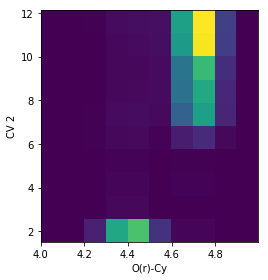

In [44]:
fig, ax = plt.subplots()
ax.hist2d(univ.data['O(r)-Cy'], univ.data['CV2'])
ax.set_aspect(0.1,'box-forced')
ax.set_xlabel('O(r)-Cy')
ax.set_ylabel('CV 2')
fig.tight_layout()
fig.savefig('CV2-v-Or-Cy.pdf')
fig

Note, `CV2` is the CV involving the hydrogen attached to the right oxygen binding to the ketone on the 3-HTMF.

This makes sense with the relative energetics of the two wells as the temperature rises: 
The slightly farther well goes down in free energy at higher temperature. 
An unbound state would likely become more entropically favored at higher temperatures, so these two wells are associated with reactant-bound and reactant-unbound states.

In [45]:
plt.close('all')

# Limit z-range

## Playground

### Test out parsing stuff

In [15]:
zrange = list((0,20)) + [11]
np.linspace(*zrange)

array([  0.,   2.,   4.,   6.,   8.,  10.,  12.,  14.,  16.,  18.,  20.])

In [7]:
zrange

[0, 20, 11]

In [8]:
len(11)

TypeError: object of type 'int' has no len()

In [10]:
float(zrange)

TypeError: float() argument must be a string or a number

In [13]:
tx = [11]
[0, tx[0], 20]

[0, 11, 20]

### Try new argument to fes_2d_cvs

In [78]:
univ = ca.Taddol('solutes.gro', 'major-endo/13-3htmf-etc/05/npt-PT-MaEn-out0.xtc')
univ.read_data()

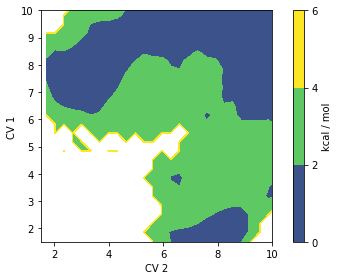

In [55]:
fig = univ.fes_2d_cvs(zrange=[0,4,3], zfinal=6)
fig

In [51]:
fig.savefig('fes-cvs-PT-MaEn-0-1us-zrange-fb.pdf')

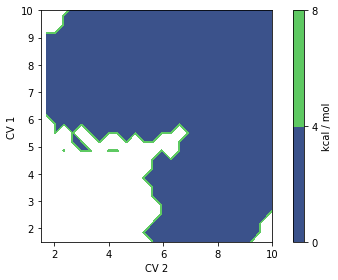

In [65]:
fig = univ.fes_2d_cvs(bins=[0,4,8])
fig

In [66]:
fig.savefig('fes-cvs-PT-MaEn-0-1us-zrange-2b.pdf')

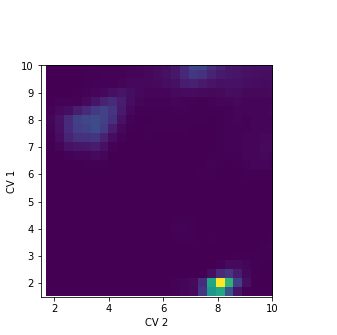

In [64]:
fig = univ.hist_2d_cvs()
fig

### Compare edges vs. midpoints

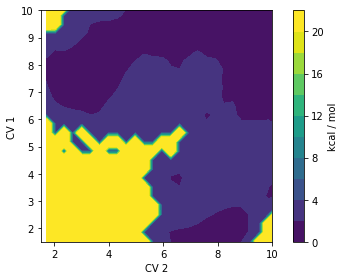

In [67]:
fig_edges = univ.fes_2d_cvs()
fig_edges

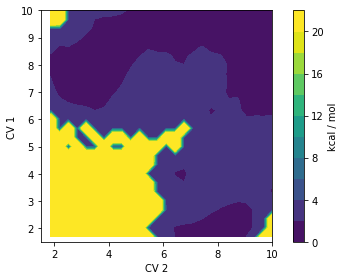

In [79]:
fig_mids = univ.fes_2d_cvs()
fig_mids

It seems that it shifts the FES by about 0.25 angstroms, which seems insignificant enough to not worry much about this. 
I'll use the midpoints going forward, but I don't think it's necessary to discard all the old plots.

In [81]:
tl

[1, 2, 3, 4, 5]

In [82]:
ca.Taddol.running_mean(tl,2)

array([ 1.5,  2.5,  3.5,  4.5])

In [84]:
type(np.array([1]))

numpy.ndarray

# CV Cut Plots

## Sandbox

In [150]:
univ.trajectory

<XTCReader npt-PT-MaEn-out15.xtc with 500001 frames of 182 atoms>

In [127]:
univ.calc_open_closed()

In [128]:
x = univ.data.loc[lambda x: (2.5 < x.CV2) & (x.CV2 < 3.5) & x.closed_TAD]['CV1']
y = univ.data.loc[lambda x: (2.5 < x.CV2) & (x.CV2 < 3.5)]['CV2']

In [130]:
len(x)

0

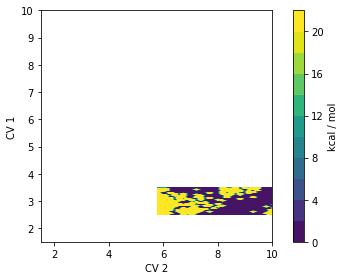

In [118]:
univ.fes_2d_cvs(x=x, y=y)

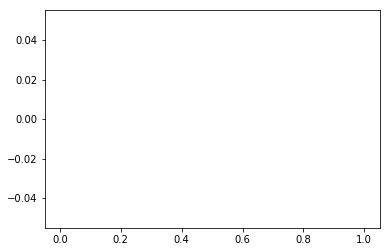

In [129]:
fig, ax = plt.subplots()
ax.hist(x)
fig

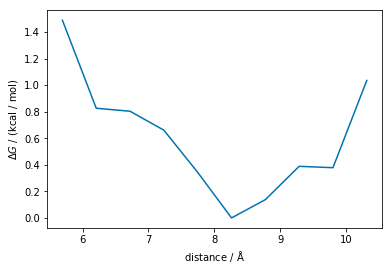

In [124]:
temp = 205

r = 0.0019872  # kcal_th/(K mol)
fig, ax = plt.subplots()

x = univ.data.loc[lambda x: (2.5 < x.CV2) & (x.CV2 < 3.5)]['CV1']
y = univ.data.loc[lambda x: (2.5 < x.CV2) & (x.CV2 < 3.5)]['CV2']

n, bins = np.histogram(x)
n = [float(j) for j in n]
prob = np.array([j / max(n) for j in n]) + 1e-40
delta_g = np.array([-r * temp * np.log(p) for p in prob])
delta_g
line, = ax.plot(bins[:-1], delta_g)
ax.set_ylabel(r'$\Delta G$ / (kcal / mol)')
ax.set_xlabel(r'distance / $\mathrm{\AA}$')

fig

In [148]:
key = 'MaEn'
i = 15

with cd(configs[key]):
    univ = ca.Taddol('../../../solutes.gro', 
                     'npt-PT-{}-out{}.xtc'.format(key, i))
    univ.calculate_distances(OlCOC1='9 11', OlCOC2='9 12', OrCOC1='7 11', OrCOC2='7 12')
    ps = []
    ps.append(plt.plot(univ.data['Time'], univ.data['OlCOC1'], label='O(l)-O(c1)')[0])
    ps.append(plt.plot(univ.data['Time'], univ.data['OlCOC2'], label='O(l)-O(c2)')[0])
    ps.append(plt.plot(univ.data['Time'], univ.data['OrCOC1'], label='O(r)-O(c1)')[0])
    ps.append(plt.plot(univ.data['Time'], univ.data['OrCOC2'], label='O(l)-O(c2)')[0])
    plt.legend(handles=ps, loc='upper left')
    univ.save_data()
plt.show()

IOError: Data of this name already exists in this store! filename: npt-PT-MaEn-out15.h5, key: time_1000ns

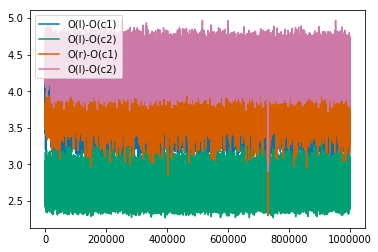

In [149]:
plt.show()

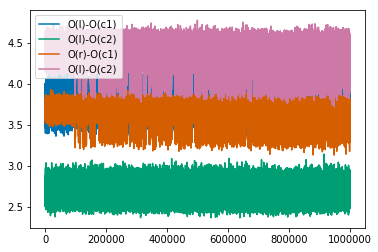

In [146]:
plt.show()

In [147]:
univ.save_data()

Saved data to npt-PT-MaEn-out0.h5[time_1000ns]


## Production

In [139]:
r = 0.0019872  # kcal_th/(K mol)

for key in configs:
    with cd(configs[key]):
        i = 0
        print 'Now starting on {} {}...'.format(key, i)
        univ = ca.Taddol('../../../solutes.gro', 
                         'npt-PT-{}-out{}.xtc'.format(key, i))
        temp = 205
        final_time = int(univ.data['Time'].iat[-1]/1000)
        if final_time > 1000:
            final_time = str(final_time/1000)+'us'
        else:
            final_time = str(final_time) + 'ns'
        file_name_end = '-rjm-PT-{}-{}-{}.pdf'.format(key, i, final_time)
        try:
            univ.read_data()
        except IOError:
            univ.calculate_distances()
            univ.calc_open_closed()
            univ.save_data()
        univ.calc_open_closed()

        x = univ.data.loc[lambda x: (2.5 < x.CV2) & (x.CV2 < 3.5) & x.closed_TAD]['CV1']
        if len(x) > 2:
            n, bins = np.histogram(x, bins=20)
            n = [float(j) for j in n]
            prob = np.array([j / max(n) for j in n]) + 1e-40
            delta_g = np.array([-r * temp * np.log(p) for p in prob])
            delta_g
            fig, ax = plt.subplots()
            line, = ax.plot(bins[:-1], delta_g)
            ax.set_ylabel(r'$\Delta G$ / (kcal / mol)')
            ax.set_xlabel(r'CV 1 / $\mathrm{\AA}$')
            fig.tight_layout()
            fig.savefig('fes-CV1-closed-shortCV2'+file_name_end)
        else:
            print('Not enough closed frames for {} {}'.format(key, i))
            
        x = univ.data.loc[lambda x: (7.5 < x.CV2) & (x.CV2 < 8.5) & x.open_TAD]['CV1']
        if len(x) > 2:
            n, bins = np.histogram(x, bins=20)
            n = [float(j) for j in n]
            prob = np.array([j / max(n) for j in n]) + 1e-40
            delta_g = np.array([-r * temp * np.log(p) for p in prob])
            delta_g
            fig, ax = plt.subplots()
            line, = ax.plot(bins[:-1], delta_g)
            ax.set_ylabel(r'$\Delta G$ / (kcal / mol)')
            ax.set_xlabel(r'CV 1 / $\mathrm{\AA}$')
            fig.tight_layout()
            fig.savefig('fes-CV1-open-longCV2'+file_name_end)
        else:
            print('Not enough open frames for {} {}'.format(key, i))

Now starting on MaEx 0...
Not enough closed frames for MaEx 0
Now starting on MiEn 0...
Not enough closed frames for MiEn 0
Now starting on MiEx 0...
Not enough closed frames for MiEx 0
Now starting on MaEn 0...
Not enough closed frames for MaEn 0


In [140]:
plt.close('all')

In [178]:
univ = ca.Taddol('solutes.gro', 'major-endo/13-3htmf-etc/05/npt-PT-MaEn-out0.xtc')
univ.read_data()

In [179]:
fig = univ.fes_2d_cvs(bins=np.linspace(0,10,11))

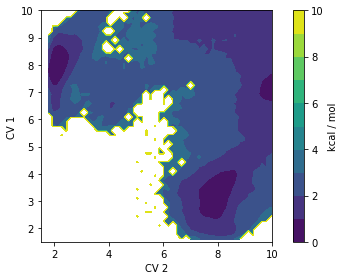

In [180]:
fig

In [181]:
ax = fig.gca()

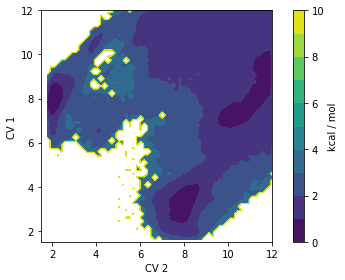

In [182]:
ax.set_ylim([1.5,12])
ax.set_xlim([1.5, 12])
fig

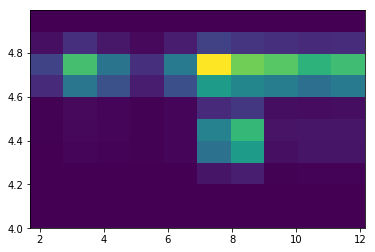

In [156]:
plt.hist2d(univ.data['CV1'], univ.data['O(r)-Cy'])
plt.show()

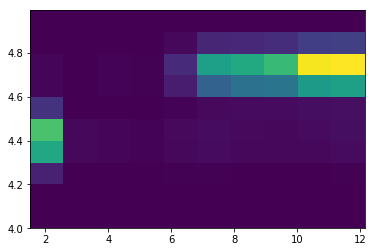

In [157]:
plt.hist2d(univ.data['CV2'], univ.data['O(r)-Cy'])
plt.show()

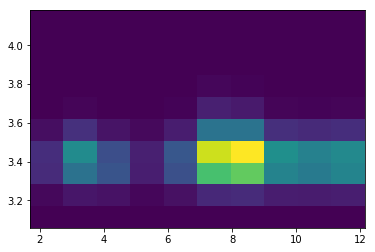

In [158]:
plt.hist2d(univ.data['CV1'], univ.data['O(l)-Cy'])
plt.show()

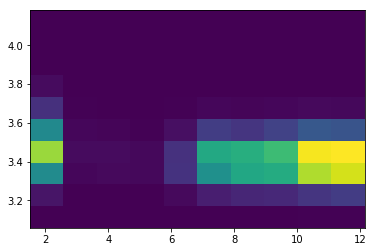

In [159]:
plt.hist2d(univ.data['CV2'], univ.data['O(l)-Cy'])
plt.show()

# Select geoms from min

## Sandbox

In [5]:
univ = ca.Taddol('solutes.gro', 'major-endo/13-3htmf-etc/05/pbc-MaEn-0.xtc')

In [5]:
univ.read_data(filename='major-endo/13-3htmf-etc/05/npt-PT-MaEn-out0.h5')

In [10]:
bool_array = (univ.data['CV1'] > 6.5) & (univ.data['CV1'] < 9.) & (univ.data['CV2'] < 3.) & (univ.data['CV2'] > 1.5)

In [12]:
univ.trajectory.frame

0

In [15]:
bool_array[10000]

False

In [20]:
solutes = univ.select_atoms('resname is 3HT or resname is CIN or resname is TAD')

with mda.Writer('minim-structs-lCV1-sCV2-rjm-PT-MaEn-0.xtc', solutes.n_atoms) as W:
    for ts in univ.trajectory:
        if bool_array[univ.trajectory.frame]:
            W.write(solutes)

In [19]:
solutes

<AtomGroup with 182 atoms>

## Production

In [25]:
cv1_cuts = [6.5, 9.]
cv2_cuts = [1.5, 3.]
name_set = 'lCV1-sCV2'

univ = ca.Taddol('solutes.gro', 'major-endo/13-3htmf-etc/05/pbc-MaEn-0.xtc')
try:
    univ.data['CV1']
except KeyError:
    univ.read_data(filename='major-endo/13-3htmf-etc/05/npt-PT-MaEn-out0.h5')

bool_array = ((univ.data['CV1'] > cv1_cuts[0]) & (univ.data['CV1'] < cv1_cuts[1]) 
              & (univ.data['CV2'] > cv2_cuts[0]) & (univ.data['CV2'] < cv2_cuts[1]))
num = len(univ.data[bool_array])
print('These cutoffs include {} frames.'.format(num))

solutes = univ.select_atoms('resname is 3HT or resname is CIN or resname is TAD')

with mda.Writer('minim-structs-'+name_set+'-rjm-PT-MaEn-0.xtc', 
                solutes.n_atoms) as W:
    for ts in univ.trajectory:
        if bool_array[univ.trajectory.frame]:
            W.write(solutes)

These cutoffs include 85723 frames.


In [23]:
cv1_cuts = [1.5, 4.]
cv2_cuts = [6.75, 8.5]
name_set = 'sCV1-lCV2'

univ = ca.Taddol('solutes.gro', 'major-endo/13-3htmf-etc/05/pbc-MaEn-0.xtc')
try:
    univ.data['CV1']
except KeyError:
    univ.read_data(filename='major-endo/13-3htmf-etc/05/npt-PT-MaEn-out0.h5')

bool_array = ((univ.data['CV1'] > cv1_cuts[0]) & (univ.data['CV1'] < cv1_cuts[1]) 
              & (univ.data['CV2'] > cv2_cuts[0]) & (univ.data['CV2'] < cv2_cuts[1]))
num = len(univ.data[bool_array])
print('These cutoffs include {} frames.'.format(num))

solutes = univ.select_atoms('resname is 3HT or resname is CIN or resname is TAD')

with mda.Writer('minim-structs-'+name_set+'-rjm-PT-MaEn-0.xtc', 
                solutes.n_atoms) as W:
    for ts in univ.trajectory:
        if bool_array[univ.trajectory.frame]:
            W.write(solutes)

These cutoffs include 65794 frames.


In [27]:
cv1_cuts = [1.5, 4.]
cv2_cuts = [6.75, 8.5]
name_set = 'sCV1-lCV2'

univ = ca.Taddol('solutes.gro', 'major-exo/13-3htmf-etc/05/pbc-MaEx-0.xtc')
try:
    univ.data['CV1']
except KeyError:
    univ.read_data(filename='major-exo/13-3htmf-etc/05/npt-PT-MaEx-out0.h5')

bool_array = ((univ.data['CV1'] > cv1_cuts[0]) & (univ.data['CV1'] < cv1_cuts[1]) 
              & (univ.data['CV2'] > cv2_cuts[0]) & (univ.data['CV2'] < cv2_cuts[1]))
num = len(univ.data[bool_array])
print('These cutoffs include {} frames.'.format(num))

solutes = univ.select_atoms('resname is 3HT or resname is CIN or resname is TAD')

with mda.Writer('minim-structs-'+name_set+'-rjm-PT-MaEx-0.xtc', 
                solutes.n_atoms) as W:
    for ts in univ.trajectory:
        if bool_array[univ.trajectory.frame]:
            W.write(solutes)

These cutoffs include 54987 frames.


In [28]:
cv1_cuts = [6.5, 9.]
cv2_cuts = [1.5, 3.]
name_set = 'lCV1-sCV2'

univ = ca.Taddol('solutes.gro', 'major-exo/13-3htmf-etc/05/pbc-MaEx-0.xtc')
try:
    univ.data['CV1']
except KeyError:
    univ.read_data(filename='major-exo/13-3htmf-etc/05/npt-PT-MaEx-out0.h5')

bool_array = ((univ.data['CV1'] > cv1_cuts[0]) & (univ.data['CV1'] < cv1_cuts[1]) 
              & (univ.data['CV2'] > cv2_cuts[0]) & (univ.data['CV2'] < cv2_cuts[1]))
num = len(univ.data[bool_array])
print('These cutoffs include {} frames.'.format(num))

solutes = univ.select_atoms('resname is 3HT or resname is CIN or resname is TAD')

with mda.Writer('minim-structs-'+name_set+'-rjm-PT-MaEx-0.xtc', 
                solutes.n_atoms) as W:
    for ts in univ.trajectory:
        if bool_array[univ.trajectory.frame]:
            W.write(solutes)
            

These cutoffs include 133980 frames.


In [29]:
len(univ.data)

500001

# g(R)

In [4]:
univ = ca.Taddol('solutes.gro', 'major-endo/13-3htmf-etc/05/pbc-MaEn-0.xtc')

reactants = univ.select_atoms('resname is 3HT or resname in CIN')
catalyst = univ.select_atoms('resname in TAD')

## g(R) class

### General Test Classes

In [5]:
from __future__ import division, absolute_import


from MDAnalysis.lib.util import blocks_of
from MDAnalysis.lib import distances
from MDAnalysis.analysis.base import AnalysisBase

class tc(AnalysisBase):
    def __init__(self, traj, b):
        super(tc, self).__init__(traj)
        print(b)
        
tc(univ.trajectory, 'hey')

TypeError: object.__init__() takes no parameters

In [21]:
class base(object):
    def __init__(self, a):
        print('base var is {}'.format(a))
    
class child(base):
    def __init__(self, a, b):
        super(child, self).__init__(a)
        print('child var is {}'.format(b))

In [7]:
child('1st', '2nd')

base var is 1st
child var is 2nd


### AnalysisBase

In [28]:
from __future__ import absolute_import
import six
from six.moves import range, zip
import inspect
import logging

import numpy as np
from MDAnalysis import coordinates
from MDAnalysis.core import AtomGroup
from MDAnalysis.lib.log import ProgressMeter#, _set_verbose

logger = logging.getLogger(__name__)


class AnalysisBase(object):
    """Base class for defining multi frame analysis
    The class it is designed as a template for creating multiframe analyses.
    This class will automatically take care of setting up the trajectory
    reader for iterating, and it offers to show a progress meter.
    To define a new Analysis, `AnalysisBase` needs to be subclassed
    `_single_frame` must be defined. It is also possible to define
    `_prepare` and `_conclude` for pre and post processing. See the example
    below.
    .. code-block:: python
       class NewAnalysis(AnalysisBase):
           def __init__(self, atomgroup, parameter, **kwargs):
               super(NewAnalysis, self).__init__(atomgroup.universe.trajectory,
                                                 **kwargs)
               self._parameter = parameter
               self._ag = atomgroup
           def _prepare(self):
               # OPTIONAL
               # Called before iteration on the trajectory has begun.
               # Data structures can be set up at this time
               self.result = []
           def _single_frame(self):
               # REQUIRED
               # Called after the trajectory is moved onto each new frame.
               # store result of `some_function` for a single frame
               self.result.append(some_function(self._ag, self._parameter))
           def _conclude(self):
               # OPTIONAL
               # Called once iteration on the trajectory is finished.
               # Apply normalisation and averaging to results here.
               self.result = np.asarray(self.result) / np.sum(self.result)
    Afterwards the new analysis can be run like this.
    .. code-block:: python
       na = NewAnalysis(u.select_atoms('name CA'), 35).run()
       print(na.result)
    """

    def __init__(self, trajectory, start=None,
                 stop=None, step=None, verbose=None, quiet=None):
        """
        Parameters
        ----------
        trajectory : mda.Reader
            A trajectory Reader
        start : int, optional
            start frame of analysis
        stop : int, optional
            stop frame of analysis
        step : int, optional
            number of frames to skip between each analysed frame
        verbose : bool, optional
            Turn on verbosity
        """
#         self._verbose = _set_verbose(verbose, quiet, default=False)
#         self._quiet = not self._verbose
        self._setup_frames(trajectory, start, stop, step)

    def _setup_frames(self, trajectory, start=None, stop=None, step=None):
        """
        Pass a Reader object and define the desired iteration pattern
        through the trajectory
        Parameters
        ----------
        trajectory : mda.Reader
            A trajectory Reader
        start : int, optional
            start frame of analysis
        stop : int, optional
            stop frame of analysis
        step : int, optional
            number of frames to skip between each analysed frame
        """
        self._trajectory = trajectory
        start, stop, step = trajectory.check_slice_indices(start, stop, step)
        self.start = start
        self.stop = stop
        self.step = step
        self.n_frames = len(range(start, stop, step))
        interval = int(self.n_frames // 100)
        if interval == 0:
            interval = 1

        # ensure _verbose is set when __init__ wasn't called, this is to not
        # break pre 0.16.0 API usage of AnalysisBase
        if not hasattr(self, '_verbose'):
            if hasattr(self, '_quiet'):
                # Here, we are in the odd case where a children class defined
                # self._quiet without going through AnalysisBase.__init__.
                warnings.warn("The *_quiet* attribute of analyses is "
                              "deprecated (from 0.16)use *_verbose* instead.",
                              DeprecationWarning)
                self._verbose = not self._quiet
            else:
                self._verbose = True
                self._quiet = not self._verbose
        self._pm = ProgressMeter(self.n_frames if self.n_frames else 1,
                                 interval=interval#, verbose=self._verbose
                                )

    def _single_frame(self):
        """Calculate data from a single frame of trajectory
        Don't worry about normalising, just deal with a single frame.
        """
        raise NotImplementedError("Only implemented in child classes")

    def _prepare(self):
        """Set things up before the analysis loop begins"""
        pass

    def _conclude(self):
        """Finalise the results you've gathered.
        Called at the end of the run() method to finish everything up.
        """
        pass

    def run(self):
        """Perform the calculation"""
        logger.info("Starting preparation")
        self._prepare()
        for i, ts in enumerate(
                self._trajectory[self.start:self.stop:self.step]):
            self._frame_index = i
            self._ts = ts
            # logger.info("--> Doing frame {} of {}".format(i+1, self.n_frames))
            self._single_frame()
            self._pm.echo(self._frame_index)
        logger.info("Finishing up")
        self._conclude()
        return self

### singleRDF

In [33]:
from __future__ import division, absolute_import


from MDAnalysis.lib.util import blocks_of
from MDAnalysis.lib import distances
# from MDAnalysis.analysis.base import AnalysisBase

class singleRDF(AnalysisBase):
    
    def __init__(self, g1, g2, nbins=75, range=(0.0, 15.0), exclusion_block=None, **kwargs):
        super(singleRDF, self).__init__(g1.universe.trajectory, **kwargs)
#         super(InterRDF, self).__init__()
#         AnalysisBase.__init__(g1.universe.trajectory, **kwargs)
        self.g1 = g1
        self.g2 = g2
        self.u = g1.universe
#         self._trajectory = self.u.trajectory

        self.rdf_settings = {'bins': nbins,
                             'range': range}
        self._exclusion_block = exclusion_block

    def _prepare(self):
        # Empty histogram to store the RDF
        count, edges = np.histogram([-1], **self.rdf_settings)
        count = count.astype(np.float64)
        count *= 0.0
        self.count = count
        self.edges = edges
        self.bins = 0.5 * (edges[:-1] + edges[1:])

        # Need to know average volume
        self.volume = 0.0

        # Allocate a results array which we will reuse
        self._result = np.zeros((1,), dtype=np.float64)
        # If provided exclusions, create a mask of _result which
        # lets us take these out
        if self._exclusion_block is not None:
            self._exclusion_mask = blocks_of(self._result,
                                             *self._exclusion_block)
            self._maxrange = self.rdf_settings['range'][1] + 1.0
        else:
            self._exclusion_mask = None

    def _single_frame(self):
        mda.lib.distances.calc_bonds(np.array([self.g1.center_of_mass()], dtype='float32'),
                                     np.array([self.g2.center_of_mass()], dtype='float32'),
                                     box=self.u.dimensions, result=self._result)
        # Maybe exclude same molecule distances
        if self._exclusion_mask is not None:
            self._exclusion_mask[:] = self._maxrange

        count = np.histogram(self._result, **self.rdf_settings)[0]
        self.count += count

        self.volume += self._ts.volume

    def _conclude(self):
        # Number of each selection
        nA = 1
        nB = 1
        N = nA * nB

        # If we had exclusions, take these into account
        if self._exclusion_block:
            xA, xB = self._exclusion_block
            nblocks = nA / xA
            N -= xA * xB * nblocks

        # Volume in each radial shell
        vol = np.power(self.edges[1:], 3) - np.power(self.edges[:-1], 3)
        vol *= 4/3.0 * np.pi

        # Average number density
        box_vol = self.volume / self.n_frames
        density = N / box_vol

        rdf = self.count / (density * vol * self.n_frames)

        self.rdf = rdf

### Original InterRDF

In [18]:
class InterRDF(AnalysisBase):
    """Intermolecular pair distribution function
    InterRDF(g1, g2, nbins=75, range=(0.0, 15.0))
    Arguments
    ---------
    g1 : AtomGroup
      First AtomGroup
    g2 : AtomGroup
      Second AtomGroup
    nbins : int (optional)
          Number of bins in the histogram [75]
    range : tuple or list (optional)
          The size of the RDF [0.0, 15.0]
    exclusion_block : tuple (optional)
          A tuple representing the tile to exclude from the distance
          array. [None]
    start : int (optional)
          The frame to start at (default is first)
    stop : int (optional)
          The frame to end at (default is last)
    step : int (optional)
          The step size through the trajectory in frames (default is
          every frame)
    Example
    -------
    First create the :class:`InterRDF` object, by supplying two
    AtomGroups then use the :meth:`run` method ::
      rdf = InterRDF(ag1, ag2)
      rdf.run()
    Results are available through the :attr:`bins` and :attr:`rdf`
    attributes::
      plt.plot(rdf.bins, rdf.rdf)
    The `exclusion_block` keyword allows the masking of pairs from
    within the same molecule.  For example, if there are 7 of each
    atom in each molecule, the exclusion mask `(7, 7)` can be used.
    .. versionadded:: 0.13.0
    """
    def __init__(self, g1, g2,
                 nbins=75, range=(0.0, 15.0), exclusion_block=None,
                 **kwargs):
        super(InterRDF, self).__init__(g1.universe.trajectory, **kwargs)
        self.g1 = g1
        self.g2 = g2
        self.u = g1.universe

        self.rdf_settings = {'bins': nbins,
                             'range': range}
        self._exclusion_block = exclusion_block

    def _prepare(self):
        # Empty histogram to store the RDF
        count, edges = np.histogram([-1], **self.rdf_settings)
        count = count.astype(np.float64)
        count *= 0.0
        self.count = count
        self.edges = edges
        self.bins = 0.5 * (edges[:-1] + edges[1:])

        # Need to know average volume
        self.volume = 0.0

        # Allocate a results array which we will reuse
        self._result = np.zeros((len(self.g1), len(self.g2)), dtype=np.float64)
        # If provided exclusions, create a mask of _result which
        # lets us take these out
        if self._exclusion_block is not None:
            self._exclusion_mask = blocks_of(self._result,
                                             *self._exclusion_block)
            self._maxrange = self.rdf_settings['range'][1] + 1.0
        else:
            self._exclusion_mask = None

    def _single_frame(self):
        distances.distance_array(self.g1.positions, self.g2.positions,
                                 box=self.u.dimensions, result=self._result)
        # Maybe exclude same molecule distances
        if self._exclusion_mask is not None:
            self._exclusion_mask[:] = self._maxrange

        count = np.histogram(self._result, **self.rdf_settings)[0]
        self.count += count

        self.volume += self._ts.volume

    def _conclude(self):
        # Number of each selection
        nA = len(self.g1)
        nB = len(self.g2)
        N = nA * nB

        # If we had exclusions, take these into account
        if self._exclusion_block:
            xA, xB = self._exclusion_block
            nblocks = nA / xA
            N -= xA * xB * nblocks

        # Volume in each radial shell
        vol = np.power(self.edges[1:], 3) - np.power(self.edges[:-1], 3)
        vol *= 4/3.0 * np.pi

        # Average number density
        box_vol = self.volume / self.n_frames
        density = N / box_vol

        rdf = self.count / (density * vol * self.n_frames)

        self.rdf = rdf

### Test it out

In [34]:
rcrdf = singleRDF(reactants, catalyst)

In [35]:
rcrdf.run()

Step 500001/500001 [100.0%]


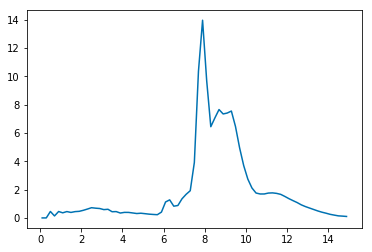

In [36]:
plt.plot(rcrdf.bins, rcrdf.rdf)

## Sandbox

In [33]:
solutes.center_of_mass()

array([ 16.76177446,  16.50244847,  16.50584995])

In [47]:
univ.atoms[0:2].positions

array([[ 12.56000042,  18.52000046,  16.40999985],
       [ 11.56000042,  17.28000069,  16.        ]], dtype=float32)

In [6]:
reactants = univ.select_atoms('resname is 3HT or resname in CIN')
catalyst = univ.select_atoms('resname in TAD')

In [52]:
for ts in univ.trajectory:
    if univ.trajectory.frame > 10:
        break
    else:
        print(reactants.center_of_mass())

[ 24.56289245  15.61536654  16.61624764]
[ 24.14600269  15.43795875  16.02795708]
[ 23.6555312   15.40071902  15.20888833]
[ 24.03353669  14.90177947  15.56263439]
[ 24.07699284  14.99378214  14.78060282]
[ 23.96306046  14.42012566  14.93890745]
[ 23.49715232  15.04642216  14.85584878]
[ 23.55577468  14.61994775  14.94998444]
[ 24.09964669  15.09156878  14.67031495]
[ 23.61167564  15.88590142  14.54943811]
[ 24.03531234  15.84271269  14.21178254]


In [67]:
dists = np.zeros([univ.trajectory.n_frames, 1])

for ts in univ.trajectory:
    mda.lib.distances.calc_bonds(np.array([reactants.center_of_mass()], dtype='float32'),
                                 np.array([catalyst.center_of_mass()], dtype='float32'),
                                 box=univ.dimensions,
                                 result=dists[univ.trajectory.frame])

In [74]:
rcrdf = mdardf.InterRDF(reactants, catalyst)

In [76]:
rcrdf.run()

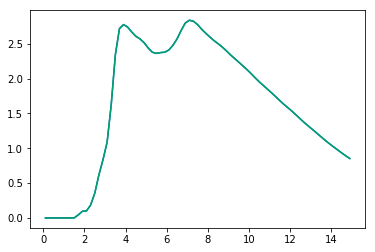

In [78]:
plt.plot(rcrdf.bins, rcrdf.rdf)
plt.show()

## Production

### Center of mass $g(R)$

Now starting on MaEx 0...


Step 500001/500001 [100.0%]


Now starting on MiEn 0...


Step 500001/500001 [100.0%]


Now starting on MiEx 0...


Step 500001/500001 [100.0%]


Now starting on MaEn 0...


Step 500001/500001 [100.0%]


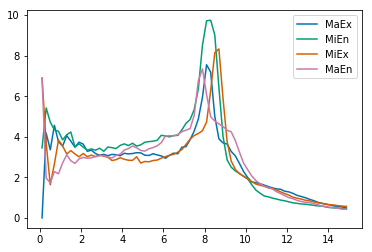

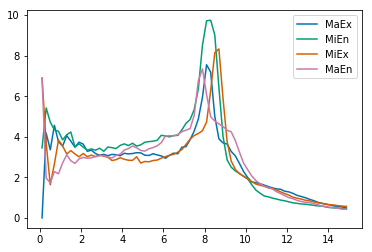

In [37]:
fig, ax = plt.subplots()

for key in configs:
    with cd(configs[key]):
        i = 0
        print 'Now starting on {} {}...'.format(key, i)
        univ = ca.Taddol('../../../solutes.gro', 
                         'npt-PT-{}-out{}.xtc'.format(key, i))
        temp = 205
        final_time = int(univ.data['Time'].iat[-1]/1000)
        if final_time > 1000:
            final_time = str(final_time/1000)+'us'
        else:
            final_time = str(final_time) + 'ns'
        file_name_end = '-rjm-PT-{}-{}-{}.pdf'.format(key, i, final_time)
        
        reactants = univ.select_atoms('resname is 3HT or resname in CIN')
        catalyst = univ.select_atoms('resname in TAD')
        
        rcrdf = singleRDF(reactants, catalyst)
        rcrdf.run()
        
        ax.plot(rcrdf.bins, rcrdf.rdf, label=key)

ax.legend()
fig

In [38]:
fig.savefig('g-of-r-rjm-PT-comb-0.pdf')

### Intermolecular O-O $g(R)$

In [39]:
univ.select_atoms('resname is 3HT or resname in CIN and name is O*')

<AtomGroup with 8 atoms>

In [50]:
univ.select_atoms('resname in TAD and name is O*')

<AtomGroup with 4 atoms>

Now starting on MaEx 0...
Now starting on MiEn 0...
Now starting on MiEx 0...
Now starting on MaEn 0...


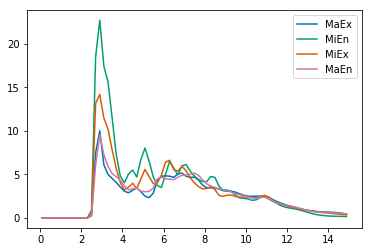

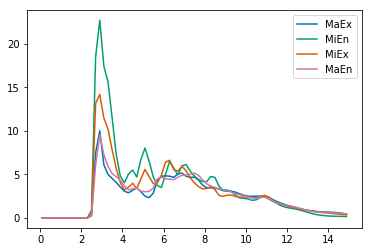

In [51]:
fig, ax = plt.subplots()

bins_all_Os = {}
rdfs_all_Os = {}

for key in sorted(configs):
    with cd(configs[key]):
        i = 0
        print 'Now starting on {} {}...'.format(key, i)
        univ = ca.Taddol('../../../solutes.gro', 
                         'npt-PT-{}-out{}.xtc'.format(key, i))
        temp = 205
        final_time = int(univ.data['Time'].iat[-1]/1000)
        if final_time > 1000:
            final_time = str(final_time/1000)+'us'
        else:
            final_time = str(final_time) + 'ns'
        file_name_end = '-rjm-PT-{}-{}-{}.pdf'.format(key, i, final_time)
        
        reactant_Os = univ.select_atoms('resname is 3HT or resname in CIN and name is O*')
        catalyst_Os = univ.select_atoms('resname in TAD and name is O*')
        
        rcrdf = mdardf.InterRDF(reactant_Os, catalyst_Os)
        rcrdf.run()
        
        bins_all_Os[key] = rcrdf.bins
        rdfs_all_Os[key] = rcrdf.rdf
        
        ax.plot(rcrdf.bins, rcrdf.rdf, label=key)

ax.legend()
fig

In [52]:
fig.savefig('g-of-r-Os-rjm-PT-comb-0.pdf')

### CV oxygen $g(R)$

In [54]:
univ.select_atoms('(resname is 3HT) and (name is O or name is OH)')

<AtomGroup with 2 atoms>

In [55]:
univ.select_atoms('resname in TAD and (name is OH or name is O1)')

<AtomGroup with 2 atoms>

Now starting on MaEn 0...
Now starting on MaEx 0...
Now starting on MiEn 0...
Now starting on MiEx 0...


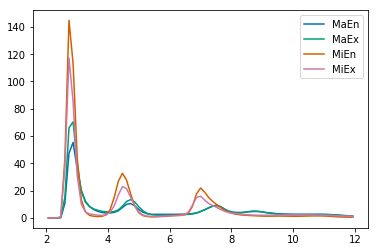

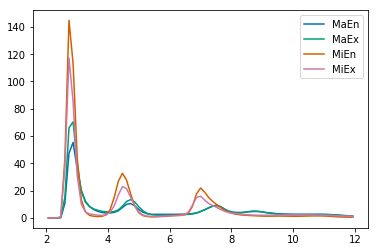

In [111]:
name_gro = 'solutes.gro'

name_gro = os.path.abspath(name_gro)

fig, ax = plt.subplots()

bins_CV_Os = {}
rdfs_CV_Os = {}

for key in sorted(configs):
    with cd(configs[key]):
        i = 0
        print 'Now starting on {} {}...'.format(key, i)
        name_xtc = 'npt-PT-{}-out{}.xtc'.format(key, i)
        univ = ca.Taddol(name_gro, name_xtc)
        temp = 205
        final_time = int(univ.data['Time'].iat[-1]/1000)
        if final_time > 1000:
            final_time = str(final_time/1000)+'us'
        else:
            final_time = str(final_time) + 'ns'
        file_name_end = '-rjm-PT-{}-{}-{}.pdf'.format(key, i, final_time)
        
        reactant_CV_Os = univ.select_atoms('(resname is 3HT) and (name is O or name is OH)')
        catalyst_CV_Os = univ.select_atoms('resname in TAD and (name is OH or name is O1)')
        
        rcrdf = mdardf.InterRDF(reactant_CV_Os, catalyst_CV_Os, range=(2.0, 12.0))
        rcrdf.run()
        
        bins_CV_Os[key] = rcrdf.bins
        rdfs_CV_Os[key] = rcrdf.rdf
        
        ax.plot(rcrdf.bins, rcrdf.rdf, label=key)

ax.legend()
fig

In [57]:
fig.savefig('g-of-r-CV-Os-rjm-PT-comb-0.pdf')

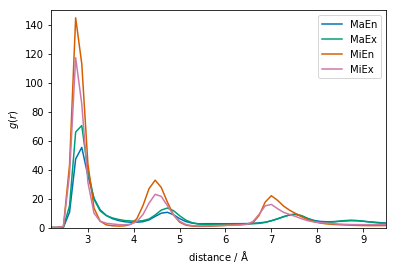

In [113]:
fig, ax = plt.subplots()
for key in sorted(rdfs_CV_Os):
    bins = bins_CV_Os[key]
    rdfs = rdfs_CV_Os[key]

    ax.plot(bins, rdfs, label=key)

ax.legend()
ax.set_ylabel(r'$g(r)$')
ax.set_xlabel('distance / $\mathrm{\AA}$')
ax.set_xlim([2.2,9.5])
ax.set_ylim([-0.2,150])
fig.savefig('g-of-r-CV-Os-rjm-PT-comb-0.pdf')

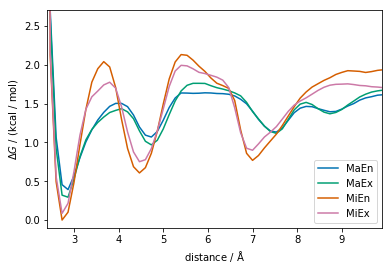

In [116]:
r = 0.0019872
temp = 205

g_CV_Os = {}
for key in rdfs_CV_Os:
    rdfs = rdfs_CV_Os[key]
    g_CV_Os[key] = - r * temp * np.log(rdfs + 1e-40)
min_g = min([min(gs) for gs in g_CV_Os.values()])
for key in g_CV_Os:
    g_CV_Os[key] = g_CV_Os[key] - min_g

fig, ax = plt.subplots()

for key in sorted(g_CV_Os):
    ax.plot(bins_CV_Os[key], g_CV_Os[key], label=key)
    ax.set_xlim([2.4,9.9])
    ax.set_ylim([-0.1,2.7])
ax.legend()
ax.set_ylabel(r'$\Delta G$ / (kcal / mol)')
ax.set_xlabel('distance / $\mathrm{\AA}$')

In [117]:
fig.savefig('fes-g-of-r-CV-Os-rjm-PT-comb-0.pdf')

# CVs: h-bonds in/out

All below in VMD numbering:
Looking at a "single open" structure
The out-of-pocket OH
* O: 8
* H: 9

The in-pocket TAD OH
* O: 6
* H: 7

3-HTMF
* H: 159
* ketone O: 132

Based on the plots [in this notebook](/notebooks/implicit_test/pt_impl/taddol/7_pt1_16walkers_wider1_longer/PCA_on_internal_coords_work.ipynb#oxygen-distances-correlations), it seems that $4 \,\mathrm{\AA}$ is a reasonable cutoff for in-pocket vs. out-of-pocket for O(l or r)-Cy distances (less than 4 is in-pocket).

In [ ]:
name_gro = 'solutes.gro'
name_xtc = 'major-endo/13-3htmf-etc/05/npt-PT-MaEn-out0.xtc'

dict_dists = {'OlH': (9, 160), 'HlO': (10, 133), 'OrH': (7, 160), 'HrO': (8, 133)}

univ = ca.Taddol(name_gro, name_xtc, format='xtc')
try:
    univ.read_data()
    univ.calculate_distances(**dict_dists)
except IOError:
    univ.calculate_distances('all', **dict_dists)
    univ.calc_open_closed()  # Good to have this saved if I can anyway
    univ.save_data()

In [6]:
olo = univ.data[lambda x: x['O(l)-Cy'] < 4][['OlH', 'HlO']].min(axis=1)
oli = univ.data[lambda x: x['O(l)-Cy'] > 4][['OlH', 'HlO']].min(axis=1)
oro = univ.data[lambda x: x['O(r)-Cy'] < 4][['OrH', 'HrO']].min(axis=1)
ori = univ.data[lambda x: x['O(r)-Cy'] > 4][['OrH', 'HrO']].min(axis=1)

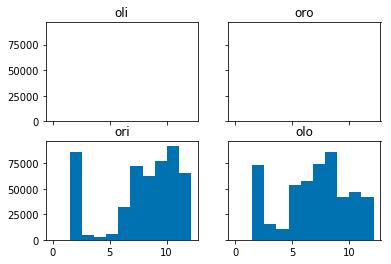

In [13]:
dists_to_plot = (olo, oli, oro, ori)
dict_dists_to_plot = {'olo': olo, 'oli': oli, 'oro': oro, 'ori': ori}

fig, axes = plt.subplots(2,2, sharex=True, sharey=True)
for i, key in enumerate(dict_dists_to_plot):
    ax = axes.flat[i]
    ax.hist(dict_dists_to_plot[key])
    ax.set_title(key)
fig

In [11]:
fig.savefig('rough-hist-new-CVs-rjm-PT-MaEn-0.pdf')

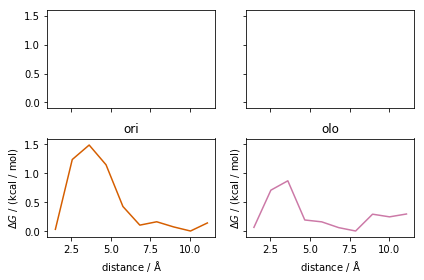

In [29]:
temp = 205
dict_data = dict_dists_to_plot

fig, axes = plt.subplots(2, 2, sharex=True, sharey=True)
r = 0.0019872  # kcal_th/(K mol)
delta_gs = []
handles = []
# Use whatever the default colors for the system are
# TODO find a more elegant way to do this
colors = mpl.rcParams['axes.prop_cycle'].by_key().values()[0]
for i, key in enumerate(dict_data):
    if len(dict_data[key]) > 50:
        n, bins = np.histogram(dict_data[key])
        n = [float(j) for j in n]
        # TODO find better way to account for zeros here rather than
        # just adding a small amount to each.
        prob = np.array([j / max(n) for j in n]) + 1e-40
        delta_g = np.array([-r * temp * np.log(p) for p in prob])
        delta_gs.append(delta_g)
        ax = axes.flat[i]
        _bins = ca.Taddol._running_mean(bins)
        line, = ax.plot(bins[:-1], delta_g, colors[i])
        handles.append(line)
        ax.set_ylabel(r'$\Delta G$ / (kcal / mol)')
        ax.set_xlabel(r'distance / $\mathrm{\AA}$')
        ax.set_ylim(-0.1, 1.6)
    ax.set_title(key)
# axes.flat[3].axis('off')
# axes.flat[3].legend(handles, ['O-O', 'O(l)-Cy', 'O(r)-Cy'],
#                     loc='center')
fig.tight_layout()
fig

# cont